In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
Pi = np.pi

Hi All,

So it occurs to me that while I can write all the diagrams I like on a board, maybe just showing you how to do things is even better.  So in this notebook, we are going to be focused on solving the Korteweg de-Vries (KdV) equation.  This comes in many forms, but the form we will work with is given by 
$$
u_{t} = u_{xxx} + uu_{x}
$$
where we suppose we have periodic boundary conditions
$$
u(x + L, t) = u(x,t)
$$
and some initial condition 
$$
u(x,0) = u_{0}(x).
$$
For the sake of argument, let us suppose that $u_{0} \in C^{\infty}(S_{L})$, or that the initial condition is an infinitely smooth periodic function with period $L$.


So how are we going to numerically solve this problem?  We are going to do so by using the Discrete Fourier Transform (DFT).  However, the first thing we are going to do is rescale our problem.  By this I mean, that we introduce the variable transformation
$$
\tilde{x} = \frac{2\pi}{L} x. 
$$
The point of this transformation is to rescale the period of the problem to be $2\pi$, which is a much more natural choice when working with the DFT.  How this works in practice is through the following chain-rule argument.  We have a function $u(x,t)$, but we want a function $u(\tilde{x},t)$, which means we need to compute
$$
\frac{\partial}{\partial x} u(\tilde{x}(x),t) = \frac{\partial u}{\partial \tilde{x}}\frac{\partial \tilde{x}}{\partial x} = \frac{2\pi}{L} \frac{\partial u}{\partial \tilde{x}}.
$$
Note, in the literature, the way you will see this usually written is as 
$$
\partial_{x} = \frac{2\pi}{L}\partial_{\tilde{x}},
$$
where the function being differentiated is implied.  In *simple* cases like this, you can then immediately infer 
$$
\partial_{x}^{3} = \left(\frac{2\pi}{L}\right)^{3}\partial^{3}_{\tilde{x}}.
$$
Please note though, if we have a more general transformation, say 
$$
\tilde{x} = f(x),
$$
then 
$$
\partial_{x} = f'(x) \partial_{\tilde{x}} = f'(f^{-1}(\tilde{x}))\partial_{\tilde{x}}.
$$
We then see that 
$$
\partial^{2}_{x} = f''(x) \partial_{\tilde{x}} + (f'(x))^{2}\partial^{2}_{\tilde{x}}.
$$
So variable transformations can get quite complicated in general.  So fair warning here, you cannot always just compute higher derivatives of transformations by raising terms to powers.  


Anyway, after we rescale, we get the problem 
$$
u_{t} = \left(\frac{2\pi}{L}\right)^{3}u_{xxx} + \frac{2\pi}{L}uu_{x}
$$
with
$$
u(x+2\pi,t) = u(x,t).
$$
You will note that I write $x$ instead of $\tilde{x}$.  As you read through the literature, you will see the phrase, "after transforming the equation, we drop the tildes", or something to that effect.  Often, we introduce so many variable changes in a problem that changing the notation is more confusing than just using the same letters over again, even though we are technically in different coordinates.  Now, we introduce both the DFT and Separation of Variables.  First, as we discussed, we introduce a mesh $x_{j}\in[0,2\pi]$ where
$$
x_{j} = j \frac{2\pi}{2N} = j\frac{\pi}{N}, ~ j = 0, \cdots, 2N.
$$
We then use the approximation
$$
u(x_{j},t) = \sum_{m=-N+1}^{N} \hat{u}_{m}(t) e^{imj\pi/N}.
$$
Correspondingly we approximate derivatives via the formula
$$
\frac{\partial^{l} u(x,t)}{\partial x^{l}} = \sum_{m=-N+1}^{N} \left(im\right)^{l}\hat{u}_{m}(t) e^{imj\pi/N}.
$$


Let us see this in action now.  Suppose we have the function
$$
u(x) = \sin^{2}(x) + \cos(x)\sin^{3}(x).
$$
How would we use Python and the DFT to compute $u'(x)$?  I would do it the following way.

-14.0624951675


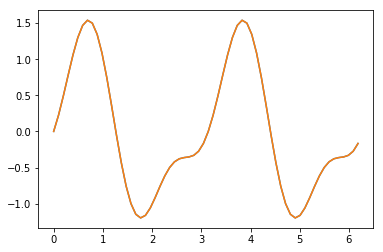

In [2]:
Nval = 2**5 # DFT's prefer you work in powers of 2.  It's not a strict rule, but a strong recommendation.
Xvals = np.linspace(0.,2.*Pi,2*Nval, endpoint = False) # again, I do everything with 2N vs N.  Again, not a strict rule.  
Dx = 1j*np.concatenate((np.arange(Nval+1),np.arange(-Nval+1,0,1,)),0) 

uvals = (np.sin(Xvals))**2. + np.cos(Xvals)*(np.sin(Xvals))**3.
Dxuvals = 2.*np.sin(Xvals)*np.cos(Xvals) - (np.sin(Xvals))**4. + 3.*((np.sin(Xvals))**2.)*((np.cos(Xvals))**2.)
Dxuapprox = np.fft.ifft( Dx*np.fft.fft(uvals) ).real

error = np.max(np.log10(np.abs(Dxuvals-Dxuapprox)))

plt.plot(Xvals,Dxuvals)
plt.plot(Xvals,Dxuapprox)
print error 

So, as we see, with relatively few modes, i.e $N=2^5=32$, we get errors on the order of $10^{-14}$, or about 14 digits of accuracy using DFTs to compute derivatives.  Note, for ease and portability, I have used numpy's built in forward DFT, i.e. 

`np.fft.fft`

and its built in inverse transform

`np.fft.ifft`

Moving on then, we now show how to solve the KdV equation in Python.   

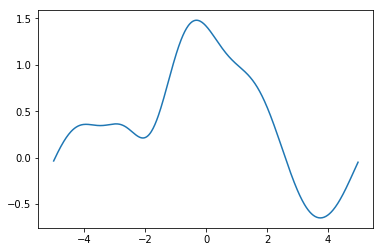

In [10]:
Lval = 10. # Interval is [-L/2,L/2]
Nval = 2**8 # Half the Number of Fourier Modes
Xvals = np.linspace(-Lval/2.,Lval/2.,2*Nval,endpoint = False) # Physical Mesh of Points
Tf = 5. # Final Time of Simulation

Dx = 2.*1j*Pi/Lval*np.concatenate((np.arange(Nval+1),np.arange(-Nval+1,0,1,)),0) #Note the variable transformation.
Dx3 = Dx**3. # Here we find the third derivative in x
dt = 1e-3 # Time step
Nsteps = int(Tf/dt) # Number of time steps
Lop = (np.ones(2*Nval)-3.*dt/4.*Dx3)**(-1.)

wn = np.zeros(2*Nval,dtype=np.complex128) # Initialize the solution vector and associated parts of multi-step solver.
wnm1 = np.zeros(2*Nval,dtype=np.complex128)
wnp1 = np.zeros(2*Nval,dtype=np.complex128)

nln = np.zeros(2*Nval,dtype=np.complex128)
nlnm1 = np.zeros(2*Nval,dtype=np.complex128)
nlnm2 = np.zeros(2*Nval,dtype=np.complex128)
nlnm3 = np.zeros(2*Nval,dtype=np.complex128)

wn[:] = np.fft.fft(2./(np.cosh(Xvals))**2.) # Fourier transform of initial condition
wnm1[:] = wn

nln[:] = Dx/2.*np.fft.fft( (np.fft.ifft(wn).real)**2. ) # Computation of nonlinearity.  
nlnm1[:] = nln
nlnm2[:] = nlnm1
nlnm3[:] = nlnm2

for jj in xrange(Nsteps): # Run the time stepper i.e. how we get from time t_n = ndt to time t_(n+1)
    nln[:] = Dx/2.*np.fft.fft( (np.fft.ifft(wn).real)**2. ) # Computation of nonlinearity
    wnp1[:] = Lop*(wn + wnm1/3. + dt*(55./24.*nln - 59./24.*nlnm1 + 37./24.*nlnm2 - 3./8.*nlnm3)) - wnm1/3.
    
    wnm1[:] = wn
    wn[:] = wnp1
    
    nlnm3[:] = nlnm2
    nlnm2[:] = nlnm1
    nlnm1[:] = nln
    
wnp1 = np.fft.ifft(wnp1).real
plt.plot(Xvals,wnp1)

So probably one of the key lines to focus on is how we compute 
$$
\frac{2\pi}{2L}\partial_{x} u^{2}.
$$
This is done via the line of code 

`Dx/2.*np.fft.fft( (np.fft.ifft(wn).real)**2. )`

Note, that what is going on here is that we are taking the solution at time $t_{n} = n dt$, which is in *frequency space*, using the inverse transform to take us back to *physical space*, computing the product $u^{2}$, and then transforming back to frequency space and then taking the derivative.  After that, we have some details regarding how to implement the time stepper.  Again, all you really need to understand for right now is that the time stepper takes all of the Fourier modes and updates them from time $t_{n}$ to time $t_{n+1}$.    